In [71]:
# # Spotify Popularity - Neural Network (TensorFlow + KerasTuner)
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # TensorFlow uyarılarını gizle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#!pip install keras_tuner
import keras_tuner as kt
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
from EngineerFeature import FeatureEngineer
from sklearn.discriminant_analysis import StandardScaler

In [72]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('feature_eng', FeatureEngineer()),
    ('scaler', StandardScaler()),
])

In [73]:
df = pd.read_csv("../final_data.csv")
df = df[:1000]

In [74]:
X = df.drop("popularity", axis=1)
y = df["popularity"]

In [ ]:
# Veri bölünmesi: Train (60%) / Val (20%) / Test (20%)
# ÖNCELİKLE TRAIN-TEST SPLIT
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)
# SONRA TRAIN-VAL SPLIT (Pipeline fit edilmeden önce!)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 * 0.8 = 0.2 (20% val)
    random_state=RANDOM_STATE
)
# ŞİMDİ Pipeline'ı SADECE TRAIN üzerinde fit et (DOĞRU YÖNTEM!)
X_train = pipeline.fit_transform(X_train, y_train)
# Val için SADECE transform (fit YOK!)
X_val = pipeline.transform(X_val)
# X_test'e DOKUNMA! Sadece en sonda final model değerlendirmesinde kullanılacak

print("✓ Pipeline SADECE train üzerinde fit edildi (Data Leakage YOK!)")
print(f"Feature sayısı: {X_train.shape[1]}")
print("Train:    ", X_train.shape, y_train.shape, "→ %60 of data (hyperparameter tuning)")
print("Val:      ", X_val.shape,   y_val.shape, "→ %20 of data (hyperparameter tuning)")

✓ Pipeline SADECE train üzerinde fit edildi (Data Leakage YOK!)
Feature sayısı: 18
X_train dtype: float64
Train:     (600, 18) (600,) → %60 of data (hyperparameter tuning)
Val:       (200, 18) (200,) → %20 of data (hyperparameter tuning)
Test:     NOT TRANSFORMED YET → %20 of data (sadece final değerlendirme için)


In [76]:
# def build_model(hp: kt.HyperParameters):
#     model = keras.Sequential()
#     # Input shape'i dinamik al
#     input_dim = X_train.shape[1]
#     model.add(layers.Input(shape=(input_dim,)))

#     # kaç tane hidden layer
#     n_layers = hp.Int("n_layers", min_value=2, max_value=5)

#     for i in range(n_layers):
#         units = hp.Int(f"units_{i}", min_value=32, max_value=128, step=32)
#         model.add(layers.Dense(units, activation="relu"))
#         model.add(layers.BatchNormalization())
#         dropout_rate = hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.3, step=0.1)
#         model.add(layers.Dropout(dropout_rate))

#     # output layer (regression → 1 nöron)
#     model.add(layers.Dense(1, activation="linear"))

#     # learning rate
#     lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, sampling="log")

#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=lr),
#         loss=keras.losses.Huber(),
#         metrics=["mae"]
#     )

#     return model


In [ ]:
def build_model(hp: kt.HyperParameters):
    model = keras.Sequential()
    # Input shape'i dinamik al
    input_dim = X_train.shape[1]
    model.add(layers.Input(shape=(input_dim,)))
    # Overfitting'i önlemek için daha basit model
    n_layers = hp.Int("n_layers", min_value=1, max_value=3)  # Daha az layer
    # L2 regularization strength
    l2_strength = hp.Float("l2_strength", min_value=1e-4, max_value=1e-2, sampling="log")

    for i in range(n_layers):
        units = hp.Int(f"units_{i}", min_value=16, max_value=64, step=16)  # Daha az unit
        model.add(layers.Dense(
            units, 
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(l2_strength)  # L2 regularization
        ))
        model.add(layers.BatchNormalization())
        # Daha yüksek dropout
        dropout_rate = hp.Float(f"dropout_{i}", min_value=0.2, max_value=0.5, step=0.1)
        model.add(layers.Dropout(dropout_rate))

    # output layer (regression → 1 nöron)
    model.add(layers.Dense(1, activation="linear"))
    # learning rate
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-3, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),    
        loss=keras.losses.Huber(),
        metrics=["mae"]    )
    return model

In [78]:
# %%
# Eski tuner loglarını temizle (yeni aramaya başlamak için)
import shutil
import os
if os.path.exists("nn_tuner_logs"):
    shutil.rmtree("nn_tuner_logs")
    print("🗑️ Eski tuner logları silindi, yeni arama başlıyor...")

tuner = kt.BayesianOptimization(
    build_model,
    objective="val_loss",
    max_trials=10,           # 15 farklı kombinasyon deneyecek
    directory="nn_tuner_logs",
    project_name="spotify_popularity_nn",
    overwrite=True           # Eski sonuçların üzerine yaz
)

tuner.search_space_summary()

🗑️ Eski tuner logları silindi, yeni arama başlıyor...
Search space summary
Default search space size: 5
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
l2_strength (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dropout_0 (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [79]:
# %%
# Overfitting'i önlemek için daha agresif early stopping
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,  # Daha düşük patience
    restore_best_weights=True,
    min_delta=0.001  # Minimum iyileşme eşiği
)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Daha az epoch
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:", best_hps.values)

Trial 10 Complete [00h 00m 04s]
val_loss: 51.73367691040039

Best val_loss So Far: 14.498263359069824
Total elapsed time: 00h 05m 23s
Best hyperparameters: {'n_layers': 3, 'l2_strength': 0.00011124999723024232, 'units_0': 48, 'dropout_0': 0.4, 'learning_rate': 0.0005299897624111874, 'units_1': 48, 'dropout_1': 0.30000000000000004, 'units_2': 64, 'dropout_2': 0.2}


In [80]:
# En iyi hyperparameter'larla final model eğitimi
# %80 train - %20 test ile pipeline'ı YENİDEN fit et (daha fazla veri!)
best_model = tuner.hypermodel.build(best_hps)

# RAW veriden yeni split yap (%80 train)
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

pipeline1 = Pipeline([
    ('feature_eng', FeatureEngineer()),
    ('scaler', StandardScaler()),
])

# Pipeline'ı %80 veri ile YENİDEN fit et
X_train_final = pipeline1.fit_transform(X_train_final, y_train_final)
X_test_final = pipeline1.transform(X_test_final)

# y'leri numpy array'e çevir
y_train_final = y_train_final.values if hasattr(y_train_final, 'values') else y_train_final
y_test_final = y_test_final.values if hasattr(y_test_final, 'values') else y_test_final

# Final training için de aynı early stopping ayarları
# early_stop = keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=10,
#     restore_best_weights=True,
#     min_delta=0.001
# )

print(f"Final training: {X_train_final.shape} (80% of data)")
print(f"Final test: {X_test_final.shape} (20% of data)")

history = best_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_test_final, y_test_final),
    epochs=100,  # Daha az epoch
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Final training: (800, 18) (80% of data)
Final test: (200, 18) (20% of data)
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 51.4626 - mae: 51.9471 - val_loss: 51.9151 - val_mae: 52.3975
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.3142 - mae: 51.7983 - val_loss: 51.8677 - val_mae: 52.3501
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 51.2365 - mae: 51.7206 - val_loss: 51.8062 - val_mae: 52.2877
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.9978 - mae: 51.4810 - val_loss: 51.7118 - val_mae: 52.1927
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.8249 - mae: 51.3096 - val_loss: 51.5844 - val_mae: 52.0658
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.5901 - mae: 51.0741 - val_loss: 51.4089 - val_mae: 51.8902
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.4448 - mae: 50.9282 - val_loss: 51.2063 - val_mae: 51.6872
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.1220 - mae: 50.

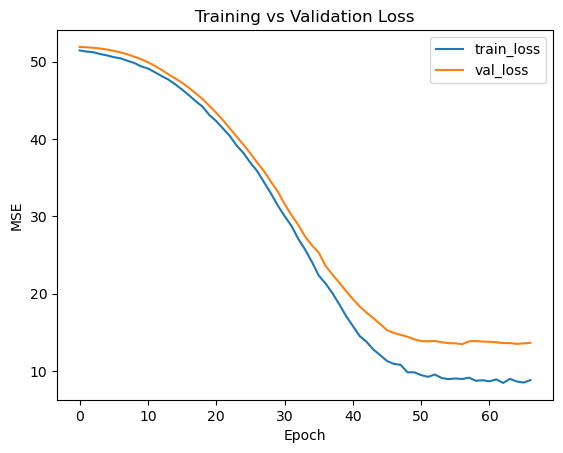

In [81]:
# %%
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


In [82]:
# Test setinde tahmin yap
y_pred_test = best_model.predict(X_test_final).ravel()

print(f"Tahmin istatistikleri:")
print(f"Min: {y_pred_test.min():.2f}, Max: {y_pred_test.max():.2f}")
print(f"100'ü aşan tahmin sayısı: {(y_pred_test > 100).sum()}")
print(f"0'ın altında tahmin sayısı: {(y_pred_test < 0).sum()}")

# Metrikler
mae  = mean_absolute_error(y_test_final, y_pred_test)
mse  = mean_squared_error(y_test_final, y_pred_test)
rmse = np.sqrt(mse)
r2   = r2_score(y_test_final, y_pred_test)

print("\n=== Test Metrikleri ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"R²   : {r2:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Tahmin istatistikleri:
Min: 7.20, Max: 97.82
100'ü aşan tahmin sayısı: 0
0'ın altında tahmin sayısı: 0

=== Test Metrikleri ===
MAE  : 13.95
RMSE : 19.17
MSE  : 367.65
R²   : 0.2886


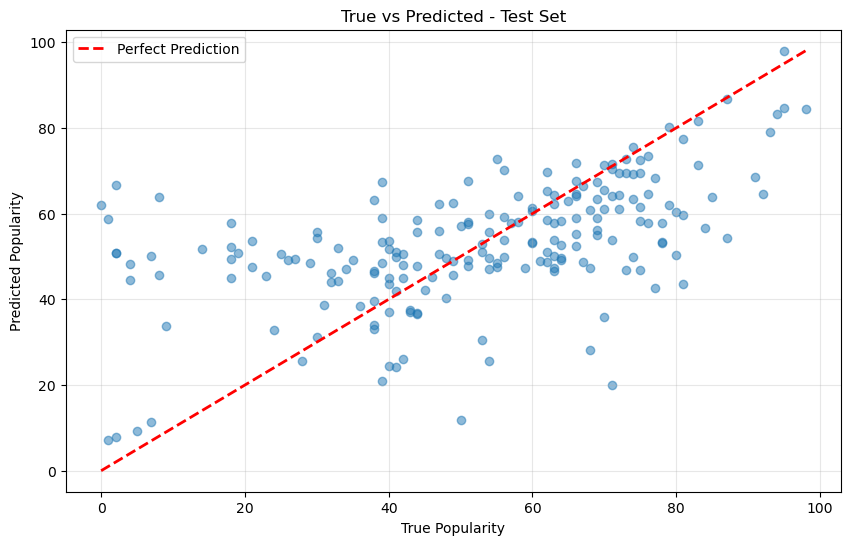

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final, y_pred_test, alpha=0.5)
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("True vs Predicted - Test Set")
# y=x referans çizgisi
min_val = min(y_test_final.min(), y_pred_test.min())
max_val = max(y_test_final.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


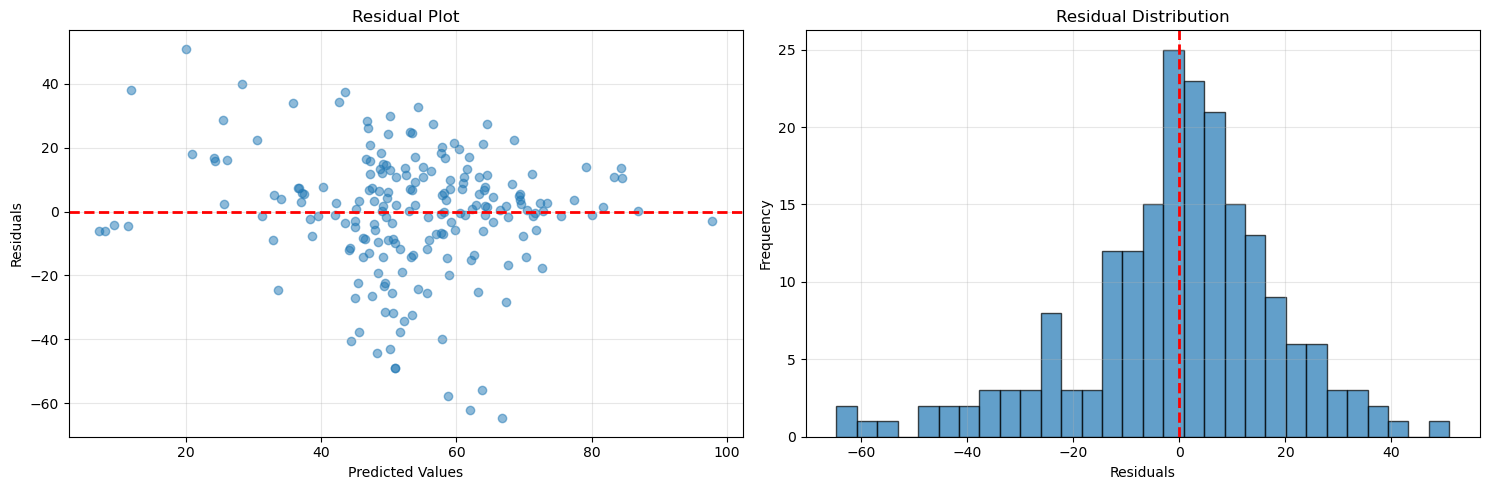

Residual Statistics:
Mean: -0.58
Std: 19.17
Min: -64.71
Max: 50.92


In [84]:
# Residual Analysis
residuals = y_test_final - y_pred_test

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Residual plot
axes[0].scatter(y_pred_test, residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot')
axes[0].grid(True, alpha=0.3)

# Residual distribution
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"Mean: {residuals.mean():.2f}")
print(f"Std: {residuals.std():.2f}")
print(f"Min: {residuals.min():.2f}")
print(f"Max: {residuals.max():.2f}")

In [85]:
# SHAP Analysis for Neural Network
import shap

# Use a subset of data for SHAP (it can be computationally expensive)
X_shap_sample = X_test_final[:100]  # 100 samples

# Create SHAP explainer for deep learning model
# Using DeepExplainer which is designed for neural networks
explainer = shap.DeepExplainer(best_model, X_train_final[:200])  # Background dataset

# Calculate SHAP values
print("Calculating SHAP values (this may take a minute)...")
shap_values_raw = explainer.shap_values(X_shap_sample)

# Handle shape - DeepExplainer returns list of arrays
if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[0]  # For regression, take first element
else:
    shap_values = shap_values_raw

print("✓ SHAP values calculated!")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Sample data shape: {X_shap_sample.shape}")

Calculating SHAP values (this may take a minute)...
✓ SHAP values calculated!
SHAP values shape: (100, 18, 1)
Sample data shape: (100, 18)


In [86]:
# Get feature names after transformation
# We need to get the feature names from the pipeline
feature_names_in = X.columns.tolist()
feature_eng = pipeline1.named_steps['feature_eng']

# After FeatureEngineer transformation, get the transformed feature names
# Create a temporary dataframe to track feature names
temp_df = feature_eng.transform(X.head(1))
if hasattr(temp_df, 'columns'):
    feature_names_out = temp_df.columns.tolist()
else:
    # If it's numpy array, create feature names manually
    feature_names_out = [f"feature_{i}" for i in range(X_test_final.shape[1])]

print(f"Number of features: {len(feature_names_out)}")
print(f"Feature names: {feature_names_out}")

Number of features: 18
Feature names: ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'playlist_count', 'album_age_log', 'playlist_count_final', 'artist_avg_popularity', 'artist_high_pop_ratio', 'artist_song_count_bin', 'avg_subgenre_popularity']


<Figure size 1000x600 with 0 Axes>

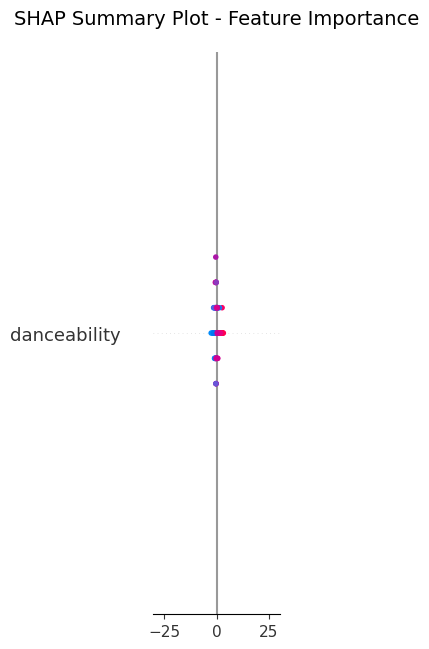

In [87]:
# SHAP Summary Plot (Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap_sample, feature_names=feature_names_out, show=False)
plt.title("SHAP Summary Plot - Feature Importance", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

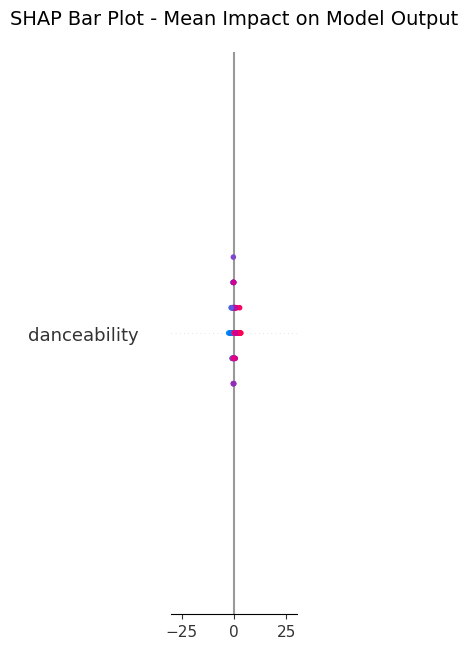

In [88]:
# SHAP Bar Plot (Mean Absolute SHAP Values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap_sample, feature_names=feature_names_out, plot_type="bar", show=False)
plt.title("SHAP Bar Plot - Mean Impact on Model Output", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Analyzing prediction for sample 0:
True popularity: 60.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted popularity: 53.11


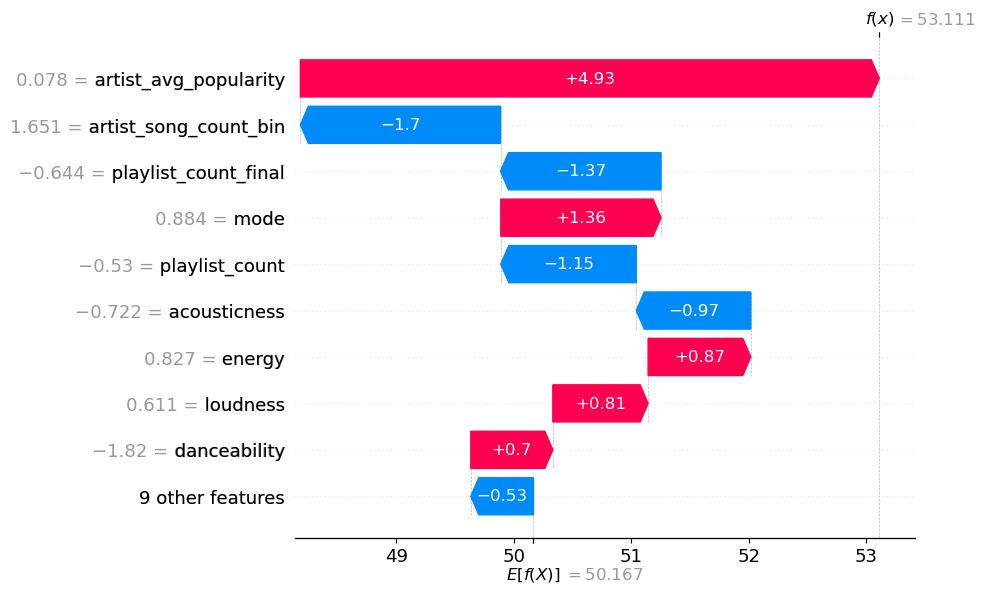

In [89]:
# SHAP Waterfall Plot for a single prediction
# Pick an interesting sample (e.g., high popularity song)
sample_idx = 0
print(f"Analyzing prediction for sample {sample_idx}:")
print(f"True popularity: {y_test_final[sample_idx]:.2f}")
print(f"Predicted popularity: {best_model.predict(X_shap_sample[sample_idx:sample_idx+1]).ravel()[0]:.2f}")

# Get base value (expected value) and convert to float
if isinstance(explainer.expected_value, (list, np.ndarray)):
    base_val = float(explainer.expected_value[0])
else:
    base_val = float(explainer.expected_value)

# Flatten SHAP values for single sample (remove extra dimension)
shap_vals_single = shap_values[sample_idx].ravel()
data_single = X_shap_sample[sample_idx].ravel()

shap.waterfall_plot(shap.Explanation(
    values=shap_vals_single,
    base_values=base_val,
    data=data_single,
    feature_names=feature_names_out
))

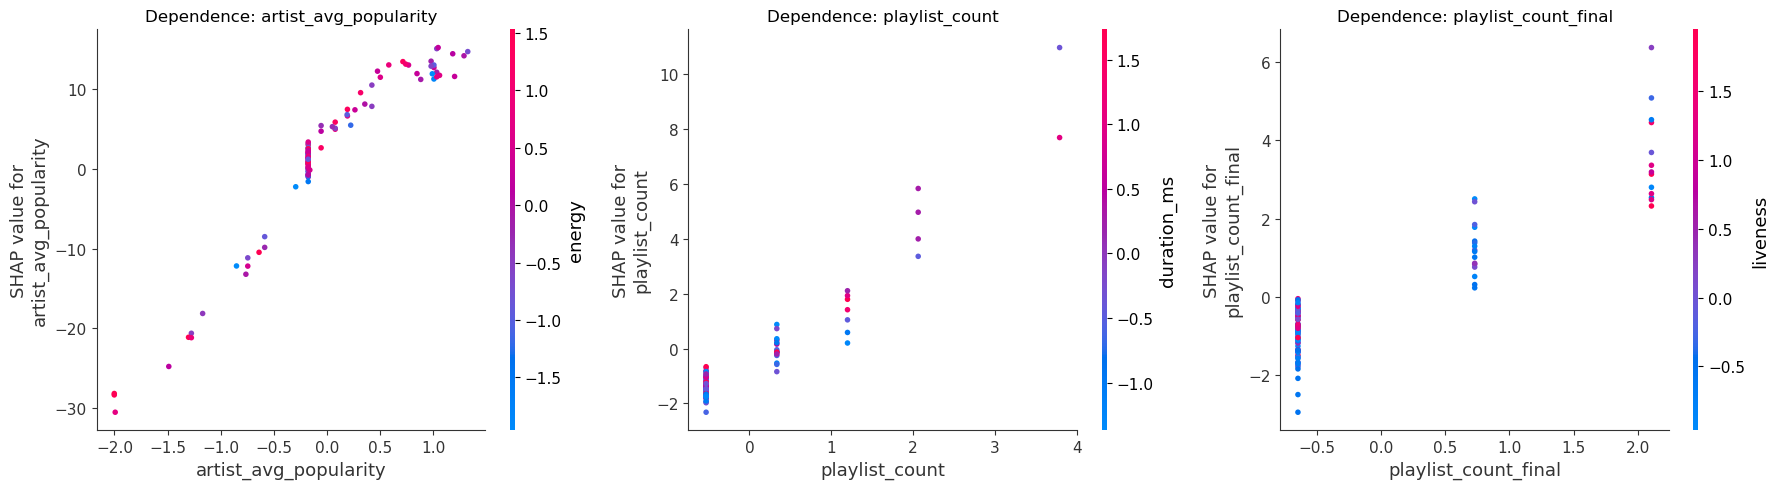

In [90]:
# SHAP Dependence Plot for top features
# Get top 3 most important features
mean_abs_shap = np.abs(shap_values).mean(axis=0).ravel()  # Flatten to 1D
top_features_idx = np.argsort(mean_abs_shap)[-3:][::-1]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Reshape shap_values and X_shap_sample to 2D if needed
shap_vals_2d = shap_values.reshape(shap_values.shape[0], -1)
X_sample_2d = X_shap_sample.reshape(X_shap_sample.shape[0], -1)

for idx, feat_idx in enumerate(top_features_idx):
    shap.dependence_plot(
        feat_idx, 
        shap_vals_2d, 
        X_sample_2d,
        feature_names=feature_names_out,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f"Dependence: {feature_names_out[feat_idx]}", fontsize=12)

plt.tight_layout()
plt.show()

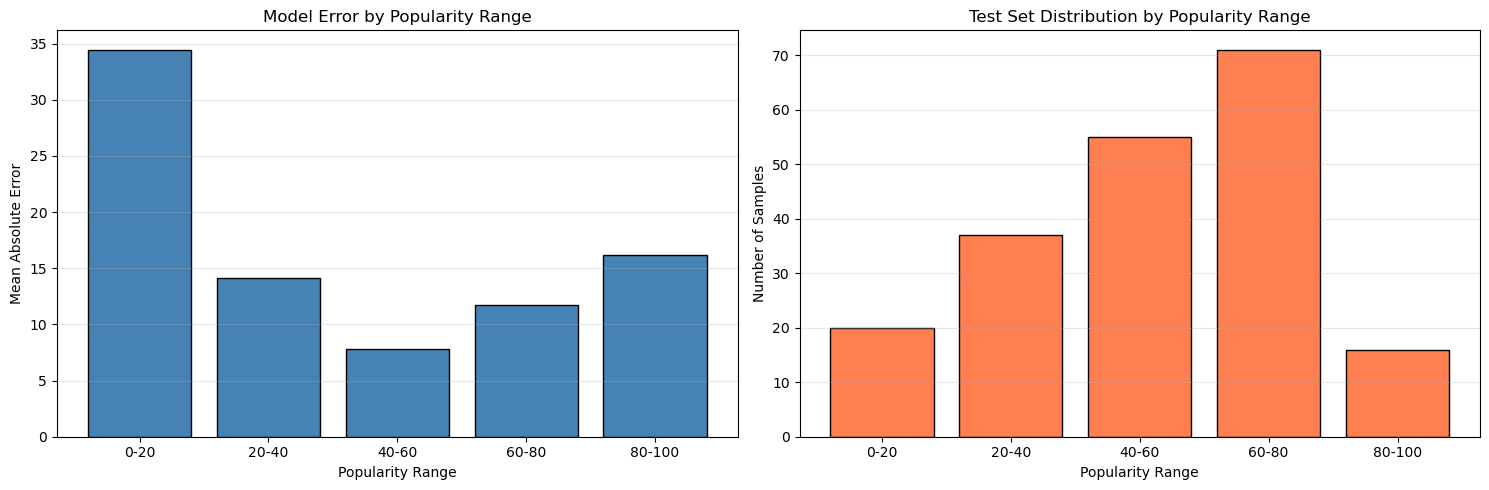


Error Analysis by Popularity Range:
Category       MAE  Count
    0-20 34.458832     20
   20-40 14.145736     37
   40-60  7.770233     55
   60-80 11.684390     71
  80-100 16.153263     16


In [91]:
# Prediction Error Analysis by Ranges
# Categorize songs by their true popularity
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
y_test_categories = pd.cut(y_test_final, bins=bins, labels=labels)

# Calculate MAE for each category
category_errors = []
for category in labels:
    mask = y_test_categories == category
    if mask.sum() > 0:
        mae_cat = mean_absolute_error(y_test_final[mask], y_pred_test[mask])
        count = mask.sum()
        category_errors.append({'Category': category, 'MAE': mae_cat, 'Count': count})

error_df = pd.DataFrame(category_errors)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE by category
axes[0].bar(error_df['Category'], error_df['MAE'], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Popularity Range')
axes[0].set_ylabel('Mean Absolute Error')
axes[0].set_title('Model Error by Popularity Range')
axes[0].grid(True, alpha=0.3, axis='y')

# Sample count by category
axes[1].bar(error_df['Category'], error_df['Count'], color='coral', edgecolor='black')
axes[1].set_xlabel('Popularity Range')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title('Test Set Distribution by Popularity Range')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nError Analysis by Popularity Range:")
print(error_df.to_string(index=False))

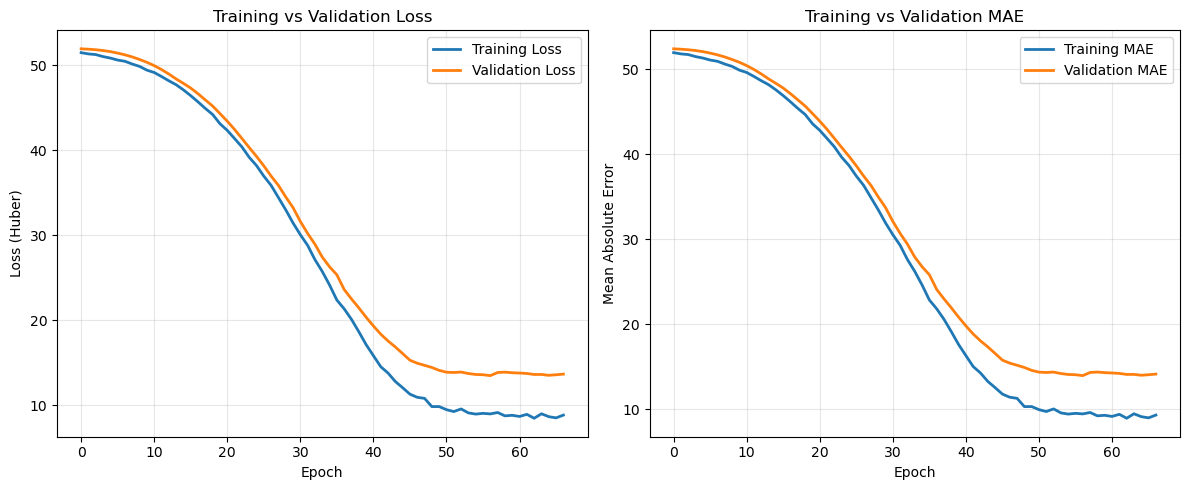


Overfitting Analysis:
Final Training Loss: 8.8393
Final Validation Loss: 13.6579
Overfitting Ratio (val/train): 1.55
⚠️ Model shows signs of overfitting!


In [92]:
# Learning Curve Analysis - Train vs Val Loss over epochs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (Huber)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.title('Training vs Validation MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for overfitting
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
overfitting_ratio = final_val_loss / final_train_loss

print(f"\nOverfitting Analysis:")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print(f"Overfitting Ratio (val/train): {overfitting_ratio:.2f}")
if overfitting_ratio > 1.5:
    print("⚠️ Model shows signs of overfitting!")
elif overfitting_ratio > 1.2:
    print("⚡ Mild overfitting detected")
else:
    print("✓ Good generalization!")

In [93]:
# Model Performance Summary
print("="*60)
print("           NEURAL NETWORK MODEL SUMMARY")
print("="*60)

# Training configuration
print("\n📊 TRAINING CONFIGURATION:")
print(f"  • Hyperparameter Tuning Split: 60% train / 20% val / 20% test")
print(f"  • Final Training Split: 80% train / 20% test")
print(f"  • Number of features: {X_train_final.shape[1]}")
print(f"  • Total training samples: {X_train_final.shape[0]}")
print(f"  • Total test samples: {X_test_final.shape[0]}")

# Best hyperparameters
print("\n🎯 BEST HYPERPARAMETERS:")
print(f"  • Number of layers: {best_hps.get('n_layers')}")
for i in range(best_hps.get('n_layers')):
    print(f"  • Layer {i+1}: {best_hps.get(f'units_{i}')} units, dropout={best_hps.get(f'dropout_{i}'):.2f}")
print(f"  • Learning rate: {best_hps.get('learning_rate'):.6f}")

# Performance metrics
print("\n📈 PERFORMANCE METRICS:")
print(f"  • Test R² Score: {r2:.4f}")
print(f"  • Test MAE: {mae:.2f}")
print(f"  • Test RMSE: {rmse:.2f}")
print(f"  • Test MSE: {mse:.2f}")

# Training results
print("\n🏋️ TRAINING RESULTS:")
print(f"  • Final Training Loss: {final_train_loss:.4f}")
print(f"  • Final Validation Loss: {final_val_loss:.4f}")
print(f"  • Number of epochs: {len(history.history['loss'])}")

print("\n" + "="*60)

           NEURAL NETWORK MODEL SUMMARY

📊 TRAINING CONFIGURATION:
  • Hyperparameter Tuning Split: 60% train / 20% val / 20% test
  • Final Training Split: 80% train / 20% test
  • Number of features: 18
  • Total training samples: 800
  • Total test samples: 200

🎯 BEST HYPERPARAMETERS:
  • Number of layers: 3
  • Layer 1: 48 units, dropout=0.40
  • Layer 2: 48 units, dropout=0.30
  • Layer 3: 64 units, dropout=0.20
  • Learning rate: 0.000530

📈 PERFORMANCE METRICS:
  • Test R² Score: 0.2886
  • Test MAE: 13.95
  • Test RMSE: 19.17
  • Test MSE: 367.65

🏋️ TRAINING RESULTS:
  • Final Training Loss: 8.8393
  • Final Validation Loss: 13.6579
  • Number of epochs: 67



In [ ]:
# %%
best_model.save("best_nn_spotify.keras")


In [ ]:
# %%
best_model.save("best_nn_spotify.h5")
